# Umsetzung Q-Agent mit Ideen aus Paper von Vos und Sabatelli
3 verschiedene Exploaration Policies:
- greedy
- e-greedy
- softmax
Hyperparameter:
- learning rate (alpha) = 0,4
- discount factor (gamma) = 0,9
- epochs = 1 Mio
- epsilon = 0,05 (gibt Variante mit epsilon decay bis e = 0, wobei e = e - E/Anzahl Epochen)
Rewards:
- Verlieren = -0,5
- Gewinnen = 4
- Hit ohne bust = 2
Es werden jeweils 50 Agenten trainiert und das Ergebnis gemittelt

In [15]:
from blackjackenv import BlackjackEnv
from qagent import QAgent
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

env = BlackjackEnv(sab=True, win_reward=4.0, lose_reward=-0.5, hit_reward=2.0)

In [16]:
# hyperparameters
learning_rate = 0.4
n_episodes = 10_000 # nach Vos 1_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05
gamma = 0.9

def initiate_50_agents(exp_policy, learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma):
    agents = []
    
    for i in range(0,50):
        agent = QAgent(
            exp_policy=exp_policy,
            alpha=learning_rate,
            initial_epsilon=start_epsilon,
            epsilon_decay=epsilon_decay,
            final_epsilon=final_epsilon,
            gamma=gamma
        )
        agents.append(agent)
    return agents

In [17]:
softmax_agents = initiate_50_agents("softmax", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [18]:
greedy_agents = initiate_50_agents("greedy", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [19]:
e_greedy_agents = initiate_50_agents("e_greedy", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [28]:
def train_agents(agents):
    envs = []
    for agent in agents:
        env = BlackjackEnv(sab=True, win_reward=4.0, lose_reward=-0.5, hit_reward=2.0)
        env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
        for episode in tqdm(range(n_episodes)):
            state, info = env.reset()
            done = False
    
            # play one episode
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
    
                # update the agent
                agent.update(state, action, reward, terminated, next_state)
    
                # update if the environment is done and the current obs
                done = terminated or truncated
                state = next_state
    
            agent.decay_epsilon()
        envs.append(env)
    return envs

In [29]:
envs_softmax = train_agents(softmax_agents)
envs_greedy = train_agents(greedy_agents)
envs_e_greedy = train_agents(e_greedy_agents)

100%|██████████| 10000/10000 [00:03<00:00, 3191.53it/s]


In [30]:
def calculate_avg_reward(envs, rolling_length):
    rolling_length = rolling_length
    avg = []
    for env in envs:
        reward_average = (
            np.convolve(
                np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        avg.append(reward_average)
    
    avg_50_agents_100_games = []
    for i in range(len(avg[0])):
        a = []
        for j in range(len(avg)):
            m = avg[j][i]
            a.append(m)
        avg_50_agents_100_games.append(np.mean(a))
    
    return avg_50_agents_100_games

In [31]:
softmax_rewards = calculate_avg_reward(envs_softmax, 1000)
greedy_rewards = calculate_avg_reward(envs_greedy, 1000)
e_greedy_rewards = calculate_avg_reward(envs_e_greedy, 1000)

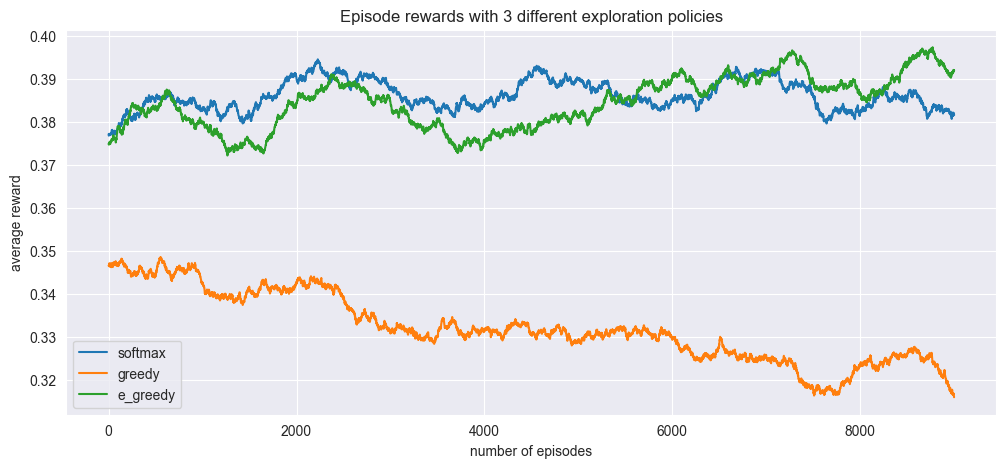

In [32]:
fig, axs = plt.subplots(figsize=(12, 5))
axs.set_title("Episode rewards with 3 different exploration policies")
axs.plot(range(len(softmax_rewards)), softmax_rewards, label = "softmax")
axs.plot(range(len(greedy_rewards)), greedy_rewards, label = "greedy")
axs.plot(range(len(e_greedy_rewards)), e_greedy_rewards, label = "e_greedy")
plt.legend()
plt.xlabel("number of episodes")
plt.ylabel("average reward")
plt.show()

In [35]:
a = [e_greedy_agents, greedy_agents, softmax_agents]
wins = []
for agents in a:
    env = BlackjackEnv(sab=True, win_reward=4.0, lose_reward=-0.5, hit_reward=2.0)
    random_agents = np.random.choice(agents, size=3)
    for random_agent in random_agents:
        agent = random_agent
        win = 0
        for episode in tqdm(range(n_episodes)):
            state, info = env.reset()
            done = False
        
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
            
                done = terminated or truncated
                state = next_state
                if reward >= 4.0:
                    win += 1
        wins.append(win)

100%|██████████| 10000/10000 [00:01<00:00, 5129.58it/s]


In [36]:
policies = ["e_greedy", "greedy", "softmax"]
for i in range(0,9,3):
    policy = policies[int(i/3)]
    sum = 0
    for j in range(i,3+i):
        sum = sum + (wins[j]/n_episodes)
    avg = sum/3
    print("{} : {}%".format(policy,avg))

e_greedy : 0.04036666666666667%
greedy : 0.0451%
softmax : 0.04103333333333333%


In [8]:
# Durchschnittlicher Reward für jeweils 100 Spiele 
# evtl. für Umsetzung nach Vos so gedacht? Immer 100'000 Spiele von 50 Agenten zusammennehmen?
averages = []
for env in envs:
    avg = []
    for i in range(100,1100,100):
        a = np.mean(np.array(env.return_queue).flatten()[i-100:i])
        avg.append(a)
    averages.append(avg)
    
rewards = []
for i in range(len(averages[0])):
    avg = []
    for j in range(len(averages)):
        m = averages[j][i]
        avg.append(m)
    rewards.append(np.mean(avg))

print(rewards) # ergibt 10 Durchschnitte aus jeweils dem Durchschnitt von 100 Spielen von 50 Agents

NameError: name 'envs' is not defined